Apple Inc. Stock Price Prediction

Imports

In [45]:
# Install necessary libraries
#!pip install yfinance pandas numpy scikit-learn tensorflow matplotlib

# Import libraries
import numpy as np # type: ignore
import pandas as pd # type: ignore
from sklearn.preprocessing import MinMaxScaler # type: ignore
from sklearn.model_selection import TimeSeriesSplit # type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, Input # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
import yfinance as yf # type: ignore
import matplotlib.pyplot as plt # type: ignore
from sklearn.model_selection import train_test_split 

Necessary functions

In [46]:
def calculate_RSI(data, window=14):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0).fillna(0)
    loss = -delta.where(delta < 0, 0).fillna(0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def add_technical_indicators(data):
    # Relative Strength Index (RSI)
    data['RSI'] = calculate_RSI(data)
    
    # Simple Moving Average (SMA)
    data['SMA'] = data['Close'].rolling(window=20).mean()

    # Exponential Moving Average (EMA)
    data['EMA'] = data['Close'].ewm(span=20, adjust=False).mean()

    
    return data

Data preprocessing

[*********************100%***********************]  1 of 1 completed
/var/folders/4f/0g73fvd97x99r498f0q7wpzh0000gn/T/ipykernel_32498/351870876.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='backfill', inplace=True)


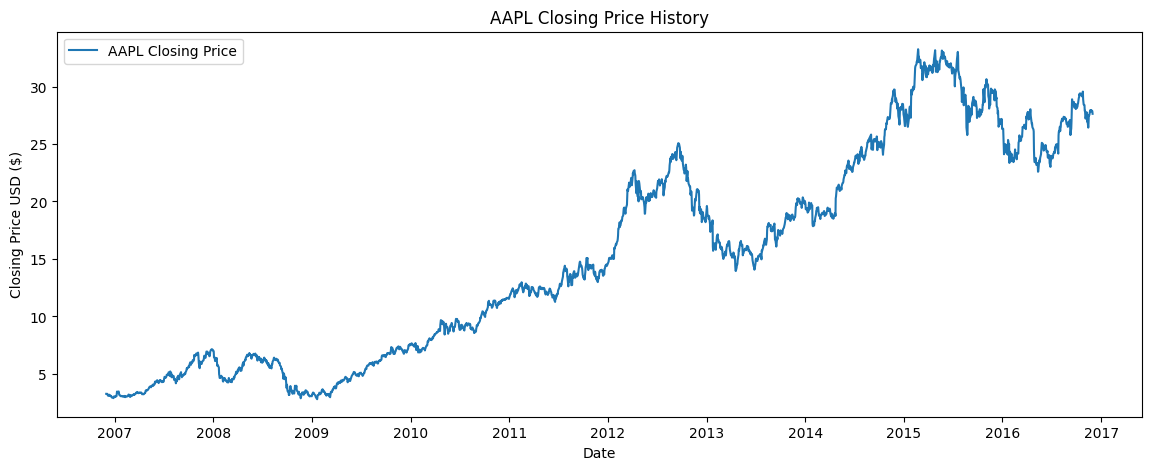

In [47]:
ticker = 'AAPL'
data = yf.download(ticker, start="2006-12-01", end="2016-12-01")

data = add_technical_indicators(data)

# Incorporating the external sentiment scores
scores = pd.read_csv("Scores.csv")['Scores'].to_list()
data['Score'] = scores

# Handling missing values: Forward fill and interpolate remaining gaps
data.fillna(method='backfill', inplace=True)
data.interpolate(method='linear', inplace=True)

# Selecting relevant features
features = ['Close', 'RSI', 'Score', 'Volume', 'SMA', 'EMA']
features = ['Close', 'RSI']

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[features])

# Creating sequences
def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 0]) 
    return np.array(sequences), np.array(targets)

seq_length = 10
X, y = create_sequences(scaled_data, seq_length)

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


plt.figure(figsize=(14, 5))
plt.plot(data['Close'], label=f'AAPL Closing Price')
plt.title(f'AAPL Closing Price History')
plt.xlabel('Date')
plt.ylabel('Closing Price USD ($)')
plt.legend()
plt.show()

Model training

In [48]:
from tensorflow.keras.layers import Bidirectional, GRU, Dropout, Dense, BatchNormalization, LSTM, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Improved Model
model = Sequential([
    Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=l2(0.02)), input_shape=(seq_length, X.shape[2])),
    Dropout(0.3),
    LSTM(100, kernel_regularizer=l2(0.02)),
    Dropout(0.3),
    Dense(25),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = model.fit(X_train, y_train, epochs=75, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/75


/Users/adirathodd/Documents/GitHub/AAPL-Sentiment-Analysis/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.7019 - val_loss: 0.0380 - learning_rate: 0.0010
Epoch 2/75
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0183 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 3/75
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0037 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 4/75
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 5/75
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0024 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 6/75
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0027 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 7/75
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - val_loss: 0.0156 - learning_rate: 0.0010
Epoch 8/75
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 9/75
120/126 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0021
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.000500000

Evaluate and predict

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


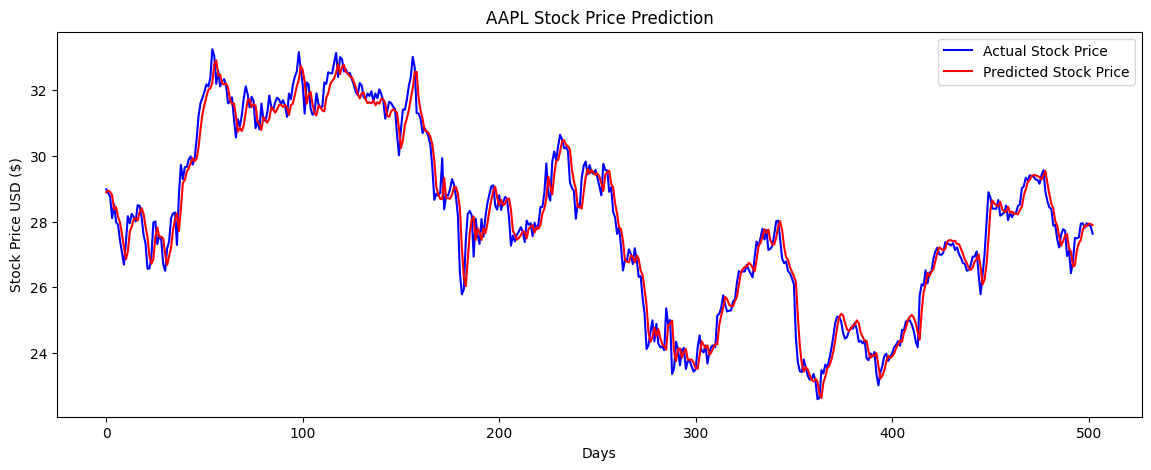

In [49]:
# Predicting on the test set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], 1))), axis=1))[:, 0]

# Rescaling the test targets
y_test_rescaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1))), axis=1))[:, 0]

plt.figure(figsize=(14, 5))
plt.plot(y_test_rescaled, color='blue', label='Actual Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Stock Price USD ($)')
plt.legend()
plt.show()

In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculating error metrics
mse = mean_squared_error(y_test_rescaled, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_rescaled, predictions)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 0.23017011400901938
Root Mean Squared Error (RMSE): 0.479760475663658
Mean Absolute Error (MAE): 0.3585545009008317
